# Data Preprocessing 

Based on findings from `01_explore_data.ipynb`, implementing comprehensive preprocessing pipeline.

## Preprocessing Steps

During one pass over the data, we will do the following preprocessing steps.

1. **Convert pseudo-RGB to grayscale** (automatic with cv2.IMREAD_GRAYSCALE)
2. **Resize to 224×224 pixels** (standardize for CNN input)
3. **Apply CLAHE** (enhance contrast + normalize quality variations)

Then, we can focus on some further cleanup after the initial preprocessing is complete.

4. **Remove duplicates** (if found during processing)
5. **Create train/val/test splits** (this is already done for us in the Kaggle dataset)
6. **Address class imbalance** (augmentation for no_tumor class)

**Note:** Outlier removal skipped - CLAHE normalizes quality variations.

In [1]:
import logging

# Configure basic logging to a file
logging.basicConfig(
    filename='duplicates.log',  # Name of the log file
    level=logging.INFO,  # Minimum logging level to capture (INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of log messages
    filemode='a'  # 'a' for append (default), 'w' for overwrite
)


## Preprocessing Steps 1-5

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import hashlib
from sklearn.model_selection import train_test_split
import json

In [3]:
# Preprocessing configuration
config = {
    'target_size': (224, 224),
    'apply_clahe': True,
    'clahe_clip_limit': 2.0,
    'clahe_tile_size': (8, 8),
    'random_seed': 42
}

# Paths
raw_dataset = Path("../data/brain_tumor_dataset")
processed_dataset = Path("../data/processed")

# Splits & Classes
splits = ['Training','Testing']
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  target_size: (224, 224)
  apply_clahe: True
  clahe_clip_limit: 2.0
  clahe_tile_size: (8, 8)
  random_seed: 42


In [4]:
image_hashes = {}

In [5]:
def get_image_hash(image_path):
    """Compute Perceptual Hash of an image"""

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Failed to read image: {img}")

    img_hash = cv2.img_hash.pHash(img).tobytes()

    return img_hash

In [6]:
def preprocess_image(img_path, target_size=(224,224), equalization=True):
    """
    Apply all preprocessing steps to a single image.
    
    Args:
        img_path: Path to input image
        target_size: Target image size (height, width)
        hist_normalization: Whether to apply histogram equalization
        
    Returns:
        Preprocessed grayscale image (numpy array)
    """

    # read image as grayscale
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
            raise ValueError(f"Failed to read image: {img_path}")
    
    # resize so all images are the same size
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)

    # apply clahe equalization
    if equalization:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        
    return img

    

In [ ]:
def preprocess_and_save_dataset(raw_dir, target_dir, config, visualize_n_duplicates=0):
    """
    Process entire raw dataset and save to new folder
    
    Args:
        raw_dir: Path to raw dataset
        target_dir: Path to save preprocessed dataset
        config: Dictionary with preprocessing parameters

    Returns:
        Dictionary with processing statistics
    """

    raw_path = Path(raw_dir)
    target_path = Path(target_dir)

    if not target_path.exists():
        os.makedirs(target_path, exist_ok=True)

    duplicate_example = 0

    # total images counts all images processed
    # class_counts is a dictionary that holds image counts per class
    stats = {'total_images': 0, 
             'class_counts': {}, 
             'duplicate_count': 0,
             'failed': []
    }    

    for split in splits:
        print(f"Processing {split} set...")
        
        for cls in classes:
            class_path_raw = raw_path / split / cls
            class_path_target = target_path / split / cls

            # iterate through each class folder
            for filename in os.listdir(class_path_raw):

                # skip hidden files and non-image files
                if filename.startswith('.') or not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    continue


                try:
                    img_path_raw = class_path_raw / filename
                    img_path_target = class_path_target / filename

                    # preprocess image
                    img = preprocess_image(img_path_raw,
                                        target_size=config['target_size'],
                                        equalization=config['apply_clahe']
                    )

                    # compute image hash for duplicate detection
                    img_hash = get_image_hash(img_path_raw)

                    # check for duplicates
                    if img_hash in image_hashes.keys():
                        stats['duplicate_count'] += 1
                        logging.info(f"Duplicate found: {img_path_raw} is a duplicate of {image_hashes[img_hash]}")

                        # visualize duplicates if requested
                        if visualize_n_duplicates > 0 and duplicate_example < visualize_n_duplicates:

                            duplicate_example += 1
                            img1 = img
                            img2 = cv2.imread(str(image_hashes[img_hash]), cv2.IMREAD_GRAYSCALE) # duplicate image

                            plt.figure(figsize=(8,4))
                            plt.suptitle(f"Duplicate Pair {duplicate_example}")

                            plt.subplot(1,2,1)
                            plt.title(f"Image 1: {filename}")
                            plt.imshow(img1, cmap='gray')
                            plt.axis('off')

                            plt.subplot(1,2,2)
                            plt.title(f"Image 2: {image_hashes[img_hash].name}")
                            plt.imshow(img2, cmap='gray')
                            plt.axis('off')

                            plt.show()
                        continue

                    # save to target folder
                    if not class_path_target.exists():
                        os.makedirs(class_path_target, exist_ok=True)

                    cv2.imwrite(str(img_path_target), img)
                    stats['total_images'] += 1
                    if cls not in stats['class_counts']:
                        stats['class_counts'][cls] = 0
                    stats['class_counts'][cls] += 1

                    # store image hash
                    image_hashes[img_hash] = img_path_target # key: image hash, value: target filepath
                except Exception as e:
                    print(f"Failed to process image {img_path_raw}: {e}")
                    stats['failed'].append(img_path_raw)

    return stats

Processing Training set...


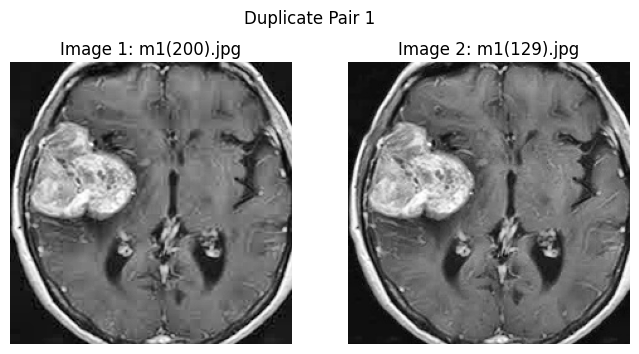

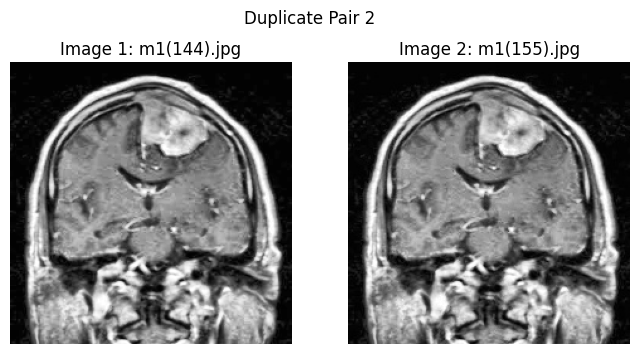

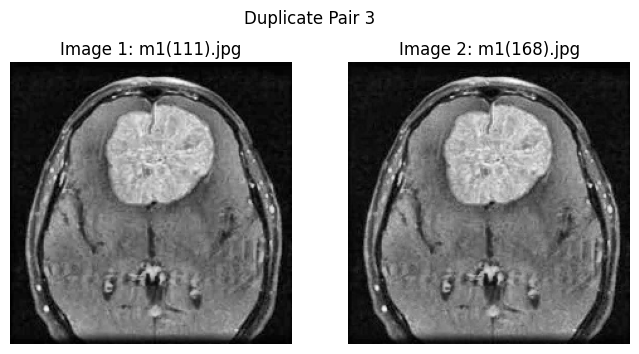

Processing Testing set...
Preprocessing complete!
Total images processed: 2851
Total duplicates found and skipped: 112
  glioma_tumor: 883 images
  meningioma_tumor: 816 images
  pituitary_tumor: 832 images
  no_tumor: 320 images


In [8]:
stats = preprocess_and_save_dataset(raw_dataset, processed_dataset, config, visualize_n_duplicates=3)
print("Preprocessing complete!")
print(f"Total images processed: {stats['total_images']}")
print(f"Total duplicates found and skipped: {stats['duplicate_count']}")
for cls, count in stats['class_counts'].items():
    print(f"  {cls}: {count} images")


In [9]:
def visualize_preprocessing_effects(sample_image_path):
    """
    Visualize the effects of preprocessing on a sample image.
    Args:
        sample_image_path: Path to a sample raw image
    Returns:
        None
    """

    raw_img = cv2.imread(str(sample_image_path), cv2.IMREAD_GRAYSCALE)

    preprocessed_img = preprocess_image(sample_image_path,
                                    target_size=config['target_size'],
                                    equalization=config['apply_clahe']
    )

    plt.figure(figsize=(8,4))
    plt.suptitle(f"Preprocessing Effects on: {sample_image_path.name}")
    plt.subplot(1, 2, 1)
    plt.title("Raw Image")
    plt.imshow(raw_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Image")
    plt.imshow(preprocessed_img, cmap='gray')
    plt.axis('off')

    plt.show()

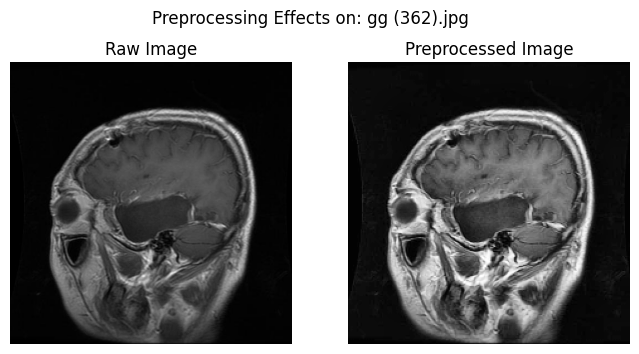

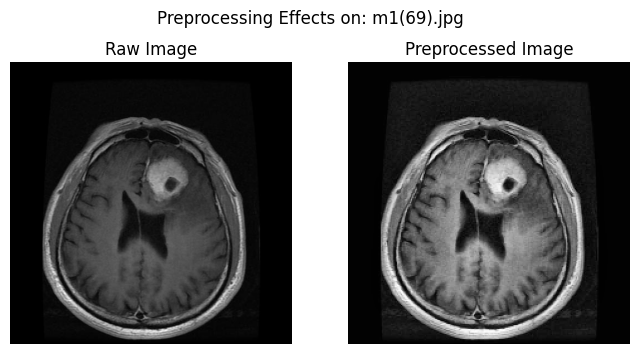

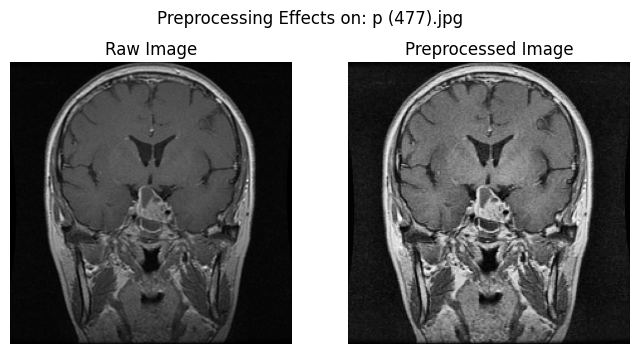

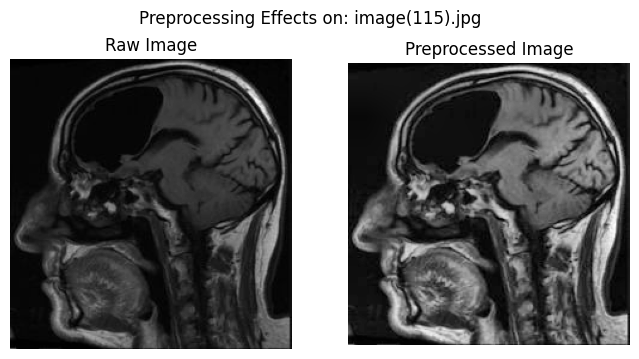

In [10]:
# show a few examples of preprocessed images before & after
def display_preprocessed_examples(raw_dir, processed_dir, classes, num_examples=3):
    raw_path = Path(raw_dir)
    processed_path = Path(processed_dir)

    for cls in classes:
        class_path_raw = raw_path / 'Training' / cls
        class_path_processed = processed_path / 'Training' / cls

        example_files = os.listdir(class_path_raw)[:num_examples]

        for filename in example_files:
            raw_img_path = class_path_raw / filename
            visualize_preprocessing_effects(raw_img_path)

display_preprocessed_examples(raw_dataset, processed_dataset, classes, num_examples=1)

## Create Validation Split

The Kaggle dataset only has Training/Testing. Create validation set from Training data.

In [11]:
def create_validation_split(processed_dir, val_size=0.2, random_seed=42):
    """
    Create a validation split from the training data.
    
    Args:
        processed_dir: Path to processed dataset
        val_size: Proportion of training data to use for validation
        random_seed: Random seed for reproducibility
    """

    processed_path = Path(processed_dir)
    training_path = processed_path / 'Training'
    validation_path = processed_path / 'Validation'

    if not validation_path.exists():
        os.makedirs(validation_path, exist_ok=True)
        
    for cls in classes:
        class_path_train = training_path / cls
        class_path_val = validation_path / cls

        if not class_path_val.exists():
            os.makedirs(class_path_val, exist_ok=True)

        image_files = os.listdir(class_path_train)
        train_files, val_files = train_test_split(image_files, test_size=val_size, random_state=random_seed)

        for filename in val_files:
            src_path = class_path_train / filename
            dst_path = class_path_val / filename

            # move file to validation folder
            os.rename(src_path, dst_path)
    print("Validation split created.")
    

In [12]:
create_validation_split(processed_dataset, val_size=0.2, random_seed=config['random_seed'])

Validation split created.


In [23]:
## Class Distribution After Preprocessing and Split
def compute_class_distribution(processed_dir):
    """
    Compute and display class distribution in each dataset split.
    
    Args:
        processed_dir: Path to processed dataset
    """

    processed_path = Path(processed_dir)

    for split in ['Training', 'Validation', 'Testing']:
        split_path = processed_path / split
        print(f"Class distribution in {split} set:")
        for cls in classes:
            class_path = split_path / cls
            count = len(os.listdir(class_path))
            print(f"  {cls}: {count} images")
        print()

compute_class_distribution(processed_dataset)

Class distribution in Training set:
  glioma_tumor: 660 images
  meningioma_tumor: 657 images
  pituitary_tumor: 661 images
  no_tumor: 316 images

Class distribution in Validation set:
  glioma_tumor: 166 images
  meningioma_tumor: 165 images
  pituitary_tumor: 166 images
  no_tumor: 79 images

Class distribution in Testing set:
  glioma_tumor: 100 images
  meningioma_tumor: 115 images
  pituitary_tumor: 74 images
  no_tumor: 105 images



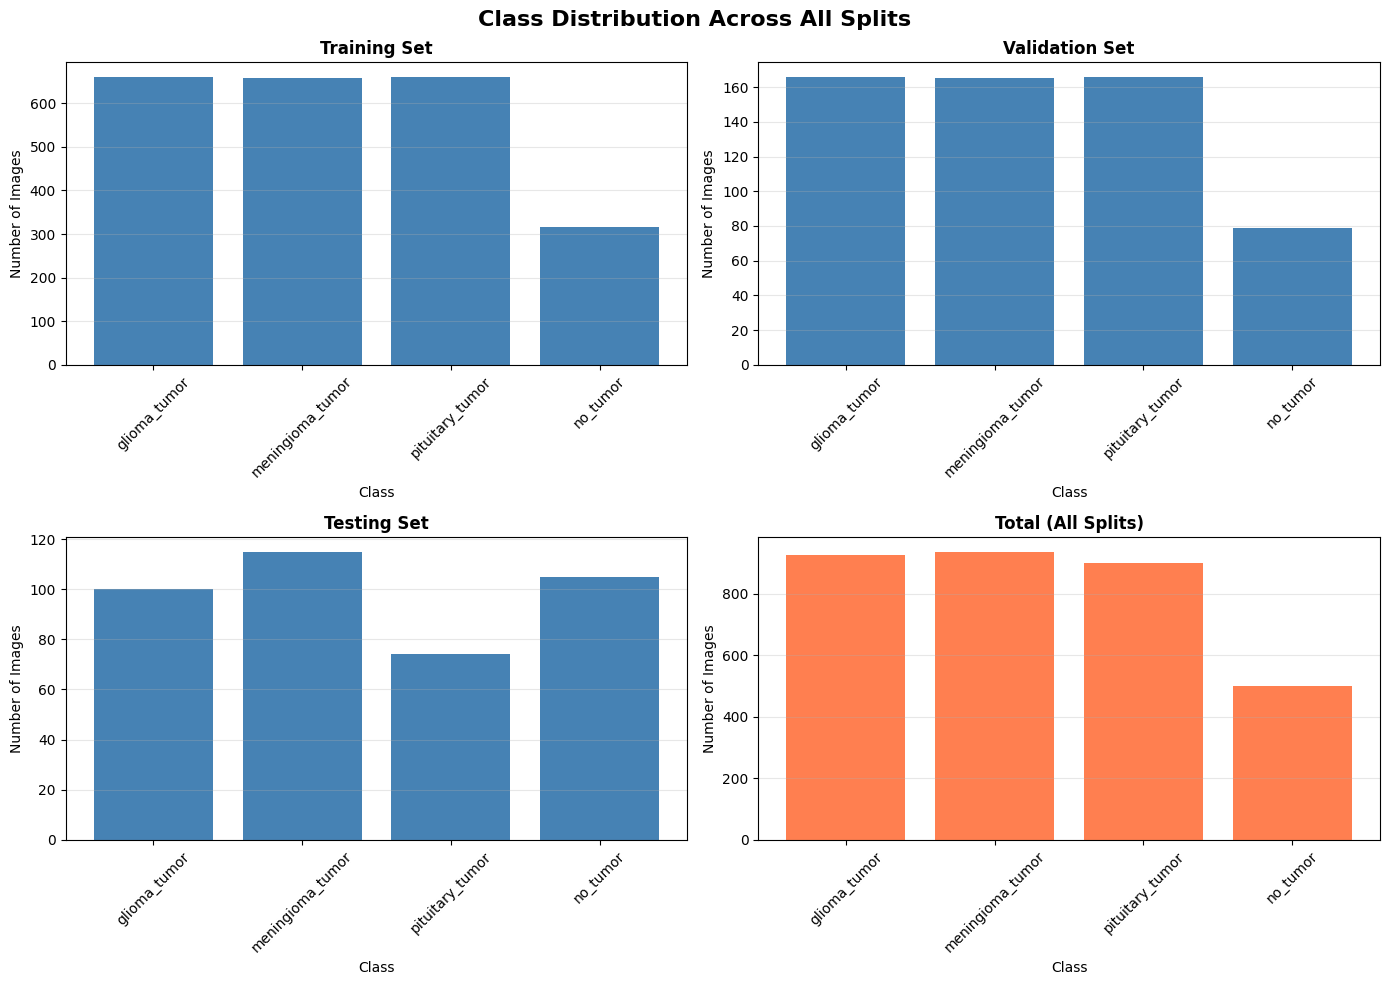

In [24]:
def visualize_all_splits_distribution(processed_dir):
    """
    Visualize class distribution for all splits in a 2x2 grid.
    
    Args:
        processed_dir: Path to processed dataset
    """
    
    processed_path = Path(processed_dir)
    splits_to_plot = ['Training', 'Validation', 'Testing']
    
    # Create 2x2 grid (4th subplot will be empty or used for summary)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Class Distribution Across All Splits', fontsize=16, fontweight='bold')
    
    for idx, split in enumerate(splits_to_plot):
        split_path = processed_path / split
        
        if not split_path.exists():
            continue
            
        class_counts = {}
        for cls in classes:
            class_path = split_path / cls
            if class_path.exists():
                count = len([f for f in os.listdir(class_path) 
                           if not f.startswith('.')])
                class_counts[cls] = count
            else:
                class_counts[cls] = 0
        
        # Calculate position
        row = idx // 2
        col = idx % 2
        
        # Plot bar chart
        axes[row, col].bar(class_counts.keys(), class_counts.values(), color='steelblue')
        axes[row, col].set_xlabel('Class', fontsize=10)
        axes[row, col].set_ylabel('Number of Images', fontsize=10)
        axes[row, col].set_title(f'{split} Set', fontsize=12, fontweight='bold')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].grid(axis='y', alpha=0.3)
    
    # Use 4th subplot for total counts across all splits
    all_counts = {}
    for cls in classes:
        total = 0
        for split in splits_to_plot:
            class_path = processed_path / split / cls
            if class_path.exists():
                total += len([f for f in os.listdir(class_path) 
                            if not f.startswith('.')])
        all_counts[cls] = total
    
    axes[1, 1].bar(all_counts.keys(), all_counts.values(), color='coral')
    axes[1, 1].set_xlabel('Class', fontsize=10)
    axes[1, 1].set_ylabel('Number of Images', fontsize=10)
    axes[1, 1].set_title('Total (All Splits)', fontsize=12, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the new function
visualize_all_splits_distribution(processed_dataset)


PREPROCESSING SUMMARY

📁 Output Directory: ../data/processed

📊 Processing Statistics:
   • Total images processed: 2851
   • Duplicates skipped: 112
   • Failed: 0

📦 Images per Class:
   • glioma_tumor        :  883 images
   • meningioma_tumor    :  816 images
   • pituitary_tumor     :  832 images
   • no_tumor            :  320 images

📈 Class Distribution in Training Set:


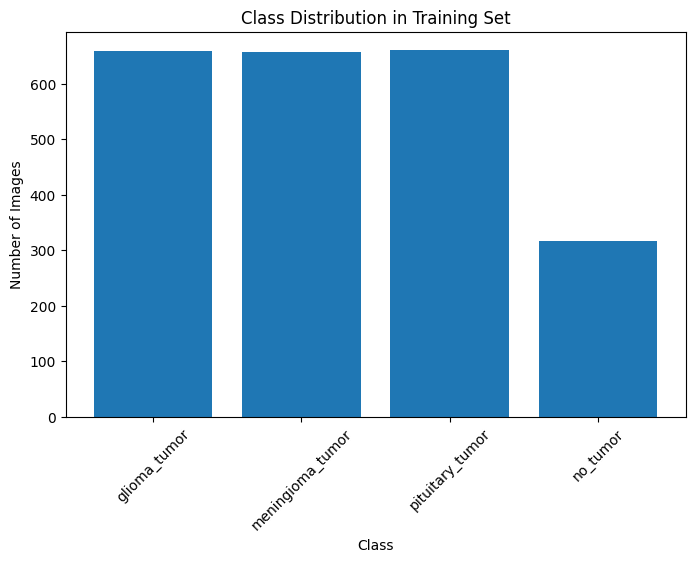


📈 Class Distribution in Validation Set:


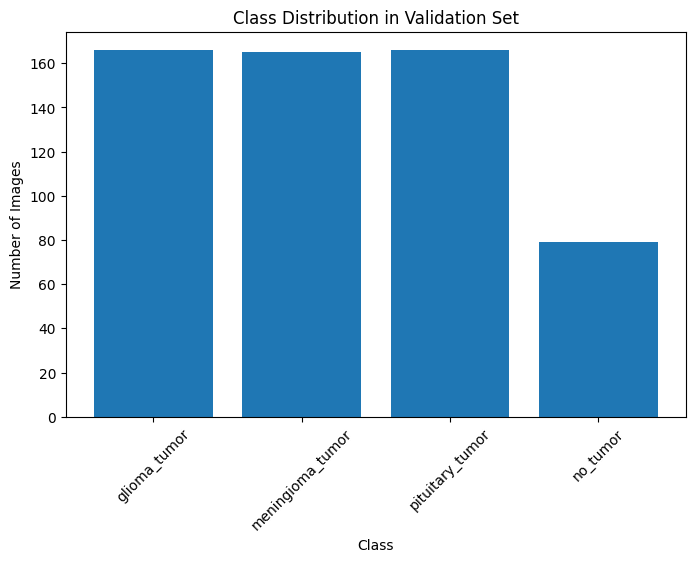


📈 Class Distribution in Testing Set:


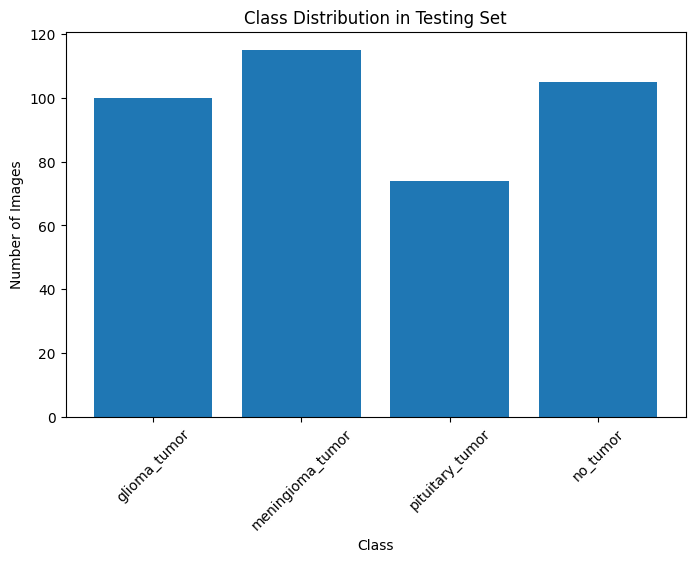


✅ Preprocessing Complete!



In [22]:
def print_preprocessing_summary(stats, processed_dir):
    """Print comprehensive preprocessing summary"""
    
    print("\n" + "="*70)
    print("PREPROCESSING SUMMARY")
    print("="*70)
    
    print(f"\n📁 Output Directory: {processed_dir}")
    print(f"\n📊 Processing Statistics:")
    print(f"   • Total images processed: {stats['total_images']}")
    print(f"   • Duplicates skipped: {stats['duplicate_count']}")
    print(f"   • Failed: {len(stats.get('failed', []))}")
    
    if stats.get('failed'):
        print(f"\n⚠️  Failed Files:")
        for filename, error in stats['failed'][:5]:
            print(f"      - {filename}: {error}")
        if len(stats['failed']) > 5:
            print(f"      ... and {len(stats['failed']) - 5} more")
    
    print(f"\n📦 Images per Class:")
    for cls, count in stats['class_counts'].items():
        print(f"   • {cls:20s}: {count:4d} images")

    for split in ['Training', 'Validation', 'Testing']:
        split_path = Path(processed_dir) / split
        print(f"\n📈 Class Distribution in {split} Set:")
        visualize_split_distribution(split_path)
    
    
    print(f"\n✅ Preprocessing Complete!")
    print("="*70 + "\n")

# Print summary
print_preprocessing_summary(stats, processed_dataset)